### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Градиентный бустинг


**Общая информация**

**Срок сдачи:** 13 июня 2022, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 13 июня, -4 балла после 08:30 20 июня, -6 баллов после 08:30 24 мая, -8 баллов после 08:30 31 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0422, Задание 4] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Считаем производные для функций потерь (1 балл)

Мы будем реализовать градиентный бустинг для 3 функций потерь:

1) MSE  $L(a(x_i), y_i) = (y_i - a(x_i)) ^ 2$

2) Экспоненциальная  $L(a(x_i), y_i) = exp( -a(x_i) y_i), y_i \in \{-1, 1\}$

3) Логистическая  $L(a(x_i), y_i) = \log (1 + exp( -a(x_i) y_i)), y_i \in \{-1, 1\}$

где $a(x_i)$ предсказание бустинга на итом объекте. 

Для каждой функции потерь напишите таргет, на который будет настраиваться каждое дерево в бустинге. 

1). k+1-е дерево будет настраиваться на $2(y_i - a_k(x_i)) $, где $a_k$ - это предсказание первых k деревьев

2). k+1-е дерево будет настраиваться на $y_i e^{-a(x_i)y_i} $, где $a_k$ - это предсказание первых k деревьев

3). k+1-е дерево будет настраиваться на $\frac{y_i exp(-a(x_i)y_i)}{1 + exp(-a(x_i)y_i)} $, где $a_k$ - это предсказание первых k деревьев

##  Реализуем градиентный бустинг (3 балла)

Реализуйте класс градиентного бустинга для классификации. Ваша реализация бустинга должна работать по точности не более чем на 5 процентов хуже чем GradientBoostingClassifier из sklearn. 


Детали реализации:

-- должно поддерживаться 3 функции потерь

-- сами базовые алгоритмы(деревья, линейные модели и тп) реализовать не надо, просто возьмите готовые из sklearn

-- в качестве функции потерь для построения одного дерева используйте MSE

-- шаг в бустинге можно не подбирать, можно брать константный

-- можно брать разные модели в качестве инициализации бустинга

-- должны поддерживаться следующие параметры:

а) число итераций
б) размер шага
в) процент случайных фичей при построении одного дерева
д) процент случайных объектов при построении одного дерева
е) параметры базового алгоритма (передавайте через **kwargs)

In [1]:
import numpy as np

from sklearn.datasets import load_wine
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

In [2]:
def sigmoid(x):
    sigm_value_x = 1.0 / (1 + np.exp(-x))
    return sigm_value_x

In [26]:
class MyGradientBoostingClassifier:

    def __init__(self, loss='MSE', learning_rate=1, n_estimators=30, colsample=100, subsample=100, *args, **kwargs):
        """
        loss -- один из 3 лоссов:
        learning_rate -- шаг бустинга
        n_estimators -- число итераций
        colsample -- процент рандомных признаков при обучнеии одного алгоритма
        colsample -- процент рандомных объектов при обучнеии одного алгоритма
        args, kwargs -- параметры  базовых моделей
        """
        # Ваш код здесь
        self.n_estimators = n_estimators
        self.loss = loss
        self.learning_rate = learning_rate
        self.colsample = colsample
        self.subsample = subsample
        self.kw = kwargs
        
        pass
    
    def fit(self, X, y, base_model=DecisionTreeRegressor, init_model=None):
        """
        X -- объекты для обучения:
        y -- таргеты для обучения
        base_model -- класс базовых моделей, например sklearn.tree.DecisionTreeRegressor
        init_model -- класс для первой модели, если None то берем константу (только для посл задания)
        """
        self.trees = []
        self.init_model = init_model()
        if not init_model:              
            self.F0 = y.mean()
        else:
            self.init_model.fit(X, y)
            self.F0 = self.init_model.predict(X)
        Fm = self.F0 
        for _ in range(self.n_estimators):
            '''X_and_y = np.column_stack((X, y))
            np.random.shuffle(X_and_y)
            X_temp = X_and_y[:X.shape[0] * self.subsample // 100,:-1]
            y_temp = X_and_y[:X.shape[0] * self.subsample // 100,-1:].T[0]
            # print(X_temp)
            print(y_temp)
            X_temp = X_temp.T
            np.random.shuffle(X_temp)
            X_temp = X_temp.T
            X_temp = X_temp[:, :X_temp.shape[1] * self.colsample // 100]'''
            tree = base_model(**self.kw)
            if self.loss == 'MSE':
                diff = y - Fm
            elif self.loss == 'Exponential':
                diff = y * np.exp(-Fm * y)
            elif self.loss == 'Logistic':
                diff = y / (np.exp(Fm * y) + 1)
            tree.fit(X, diff)
            # print(tree.predict(X))
            Fm += self.learning_rate * tree.predict(X)
            self.trees.append(tree)
        return self
        
    def predict(self, X):
        '''y_hat = self.F0
        for tree in self.trees:
            np.random.shuffle(X)
            X_temp = X[:X.shape[0] * self.subsample // 100,:]
            # print(X_temp)
            X_temp = X_temp.T
            np.random.shuffle(X_temp)
            X_temp = X_temp.T
            X_temp = X_temp[:, :X_temp.shape[1] * self.colsample // 100]
            y_hat += self.learning_rate * tree.predict(X_temp)'''
        if self.init_model:
            self.F0 = self.init_model.predict(X)
        y_hat = self.F0 + self.learning_rate * np.sum([tree.predict(X) for tree in self.trees], axis=0)
        if self.loss != 'MSE':
            med = 0
            # y_hat = sigmoid(y_hat)
            # print(y_hat)
            y_hat[np.where(y_hat > med)] = 1
            y_hat[np.where(y_hat <= med)] = -1
        return  y_hat      
        



In [51]:
my_clf = MyGradientBoostingClassifier()
clf = GradientBoostingClassifier()

In [52]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target, 
                                                    random_state=42)

In [53]:
my_clf.fit(X_train, y_train)
y_pred = my_clf.predict(X_test)
y_pred

array([0., 2., 2., 1., 1., 2., 1., 0., 2., 1., 0., 1., 0., 1., 1., 0., 0.,
       2.])

In [54]:
clf.fit(X_train, y_train)
y_pred_l = clf.predict(X_test)
y_pred_l

array([0, 1, 2, 1, 1, 2, 1, 0, 2, 1, 0, 1, 0, 1, 1, 0, 0, 2])

In [55]:
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.9444444444444444
1.0


In [200]:
y_pred=clf.predict(X_test)
y_pred

array([0, 1, 2, 1, 1, 2, 1, 0, 2, 1, 0, 1, 0, 1, 1, 0, 0, 2])

In [201]:
my_clf.fit(X_train, y_train)
y_pred=my_clf.predict(X_test)
y_pred

[0. 2. 2. 1. 1. 2. 0. 0. 2. 1. 0. 1. 0. 1. 1. 0. 0. 2.]


array([0., 2., 2., 1., 1., 2., 0., 0., 2., 1., 0., 1., 0., 1., 1., 0., 0.,
       2.])

## Подбираем параметры (2 балла)

Давайте попробуем применить Ваш бустинг для предсказаний цены домов в Калифорнии. Чтобы можно было попробовтаь разные функции потерь, переведем по порогу таргет в 2 класса: дорогие и дешевые дома.

В задании нужно

1) Построить график точности в зависимости от числа итераций на валидации.

2) Подобрать оптимальные параметры Вашего бустинга на валидации. 


In [4]:
from sklearn.metrics import f1_score
from sklearn.model_selection import GroupKFold, cross_val_score, GridSearchCV

In [5]:
from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True)

In [6]:
# Превращаем регрессию в классификацию
y = (y > 2.0).astype(int)
print(X.shape, y.shape)

(20640, 8) (20640,)


In [7]:
y = 2 * (y - 1/2)

In [11]:
my_clf = MyGradientBoostingClassifier(loss='Exponential')
my_clf.fit(X, y).predict(X)

array([ 1.,  1.,  1., ..., -1., -1., -1.])

In [ ]:
from tqdm import tqdm

n_estimators_list = np.arange(200, 619, 20) 
# alpha_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
scores = []

for n_est in tqdm(n_estimators_list):
    clf = MyGradientBoostingClassifier(
        loss='Exponential',
        n_estimators = n_est,
        max_depth=3,
        learning_rate=0.01
    )
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, random_state=42)
    clf.fit(X_train, y_train)
    score = f1_score(clf.predict(X_test), y_test)
    scores.append(score)


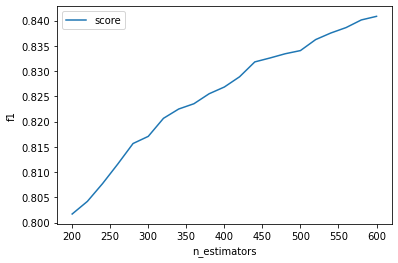

In [189]:
import matplotlib.pyplot as plt 

plt.plot(n_estimators_list, scores, label='score')
plt.xlabel('n_estimators')
plt.ylabel('f1')
plt.legend()
plt.show()

In [13]:
clf = MyGradientBoostingClassifier(
        loss='Exponential',
        n_estimators = 600,
        max_depth = 3,
        learning_rate = 0.01,
        colsample = 1,
        subsample = 1
    )
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)
clf.fit(X_train, y_train)
score = f1_score(clf.predict(X_test), y_test)
score

0.8278599783471671

## BooBag BagBoo (1 балл)



Попробуем объединить бустинг и бэгинг. Давайте

1) в качестве базовой модели брать не дерево решений, а случайный лес (из sklearn)

2) обучать N бустингов на бустрапированной выборке, а затем предикт усреднять

Попробуйте обе этих стратегии на данных из прошлого задания. Получилось ли улучшить качество? Почему?

In [18]:
from sklearn.ensemble import RandomForestRegressor

In [64]:
my_clf = MyGradientBoostingClassifier(loss='Exponential')
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)
my_clf.fit(X_train, y_train, base_model=RandomForestRegressor)
score = f1_score(my_clf.predict(X_test), y_test)
score

0.8607506138197124

In [65]:
N = 10

In [ ]:
clfs = []
for _ in range(N):
    my_clf = MyGradientBoostingClassifier(loss='Exponential')
    
    my_clf.fit(X_train, y_train)
    clfs.append(my_clf)

In [80]:
y_pred = 0
for clf in clfs:
    y_pred += clf.predict(X_test)
y_pred = 1 / N * y_pred
y_pred[np.where(y_pred > 0)] = 1
y_pred[np.where(y_pred <= 0)] = -1
print(sum(y_pred))
print(y_test)
score = f1_score(y_pred, y_test)
score

-864.0
[-1. -1.  1. ... -1. -1.  1.]


0.8073050008533881

In [ ]:
Качество не улучшилось, хотя должно бы.

## Умная инициализация (1 балл)

Попробуйте брать в качестве инициализации бустинга не константу, а какой-то алгоритм и уже от его предикта стартовать итерации бустинга. Попробуйте разные модели из sklearn: линейные модели, рандом форест, svm..

Получилось ли улучшить качество? Почему?



In [29]:
from sklearn.linear_model import LogisticRegression

In [31]:
my_clf = MyGradientBoostingClassifier(loss='Exponential')
my_clf.fit(X_train, y_train, init_model=LogisticRegression, base_model=RandomForestRegressor)
score = f1_score(my_clf.predict(X_test), y_test)
score

/home/denis_system/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.861344537815126

In [ ]:
Качество немного выросло. Возможно, это связано с тем, что начальное приближение лучше, 
и внутренние модели успевают лучше обучиться.

## Фидбек (бесценно)

* Какие аспекты обучения  ансамблей Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

